# Importing Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision import transforms , datasets
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader 
from torchvision.models import resnet50, vgg16

In [2]:
print(torch.cuda.is_available())

True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Validation

In [4]:
def data_info(PATH = '/kaggle/input/brain-tumor-mri-dataset/Training/'):
    data_dict = {}
    image_extensions = [".jpg", ".jpeg", ".png"]
    for dirname, _, filenames in os.walk(PATH):
        if dirname == PATH:
            continue
        image_count = 0
        corrupted_images = 0
        for file in os.listdir(dirname):
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_count += 1
        image_class = dirname.split('/')[-1]
        data_dict[image_class] = {"images_count": image_count , "corrupted" : corrupted_images}
            
    return data_dict

In [5]:
diction = data_info()

In [6]:
diction

{'pituitary': {'images_count': 1457, 'corrupted': 0},
 'notumor': {'images_count': 1595, 'corrupted': 0},
 'meningioma': {'images_count': 1339, 'corrupted': 0},
 'glioma': {'images_count': 1321, 'corrupted': 0}}

In [7]:
categories = list(diction.keys())
values = list(diction.values())
image_counts = [v['images_count'] for v in values]


In [8]:
categories

['pituitary', 'notumor', 'meningioma', 'glioma']

In [9]:
total = sum(image_counts)
print(total)

5712


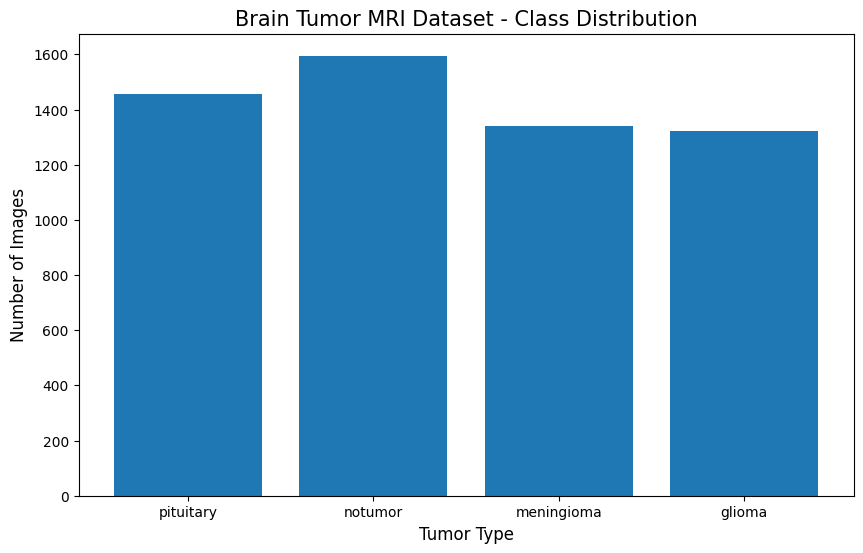

In [10]:
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, image_counts)

plt.title("Brain Tumor MRI Dataset - Class Distribution", fontsize=15)
plt.xlabel("Tumor Type", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=0) 
plt.show()

# Data Processing

In [11]:
TRAIN_PATH= '/kaggle/input/brain-tumor-mri-dataset/Training'
TEST_PATH = '/kaggle/input/brain-tumor-mri-dataset/Testing'
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

data_transformations= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
]
   
)

train_dataset = datasets.ImageFolder(TRAIN_PATH,transform= data_transformations)
test_dataset = datasets.ImageFolder(TEST_PATH,transform= data_transformations)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Visualize

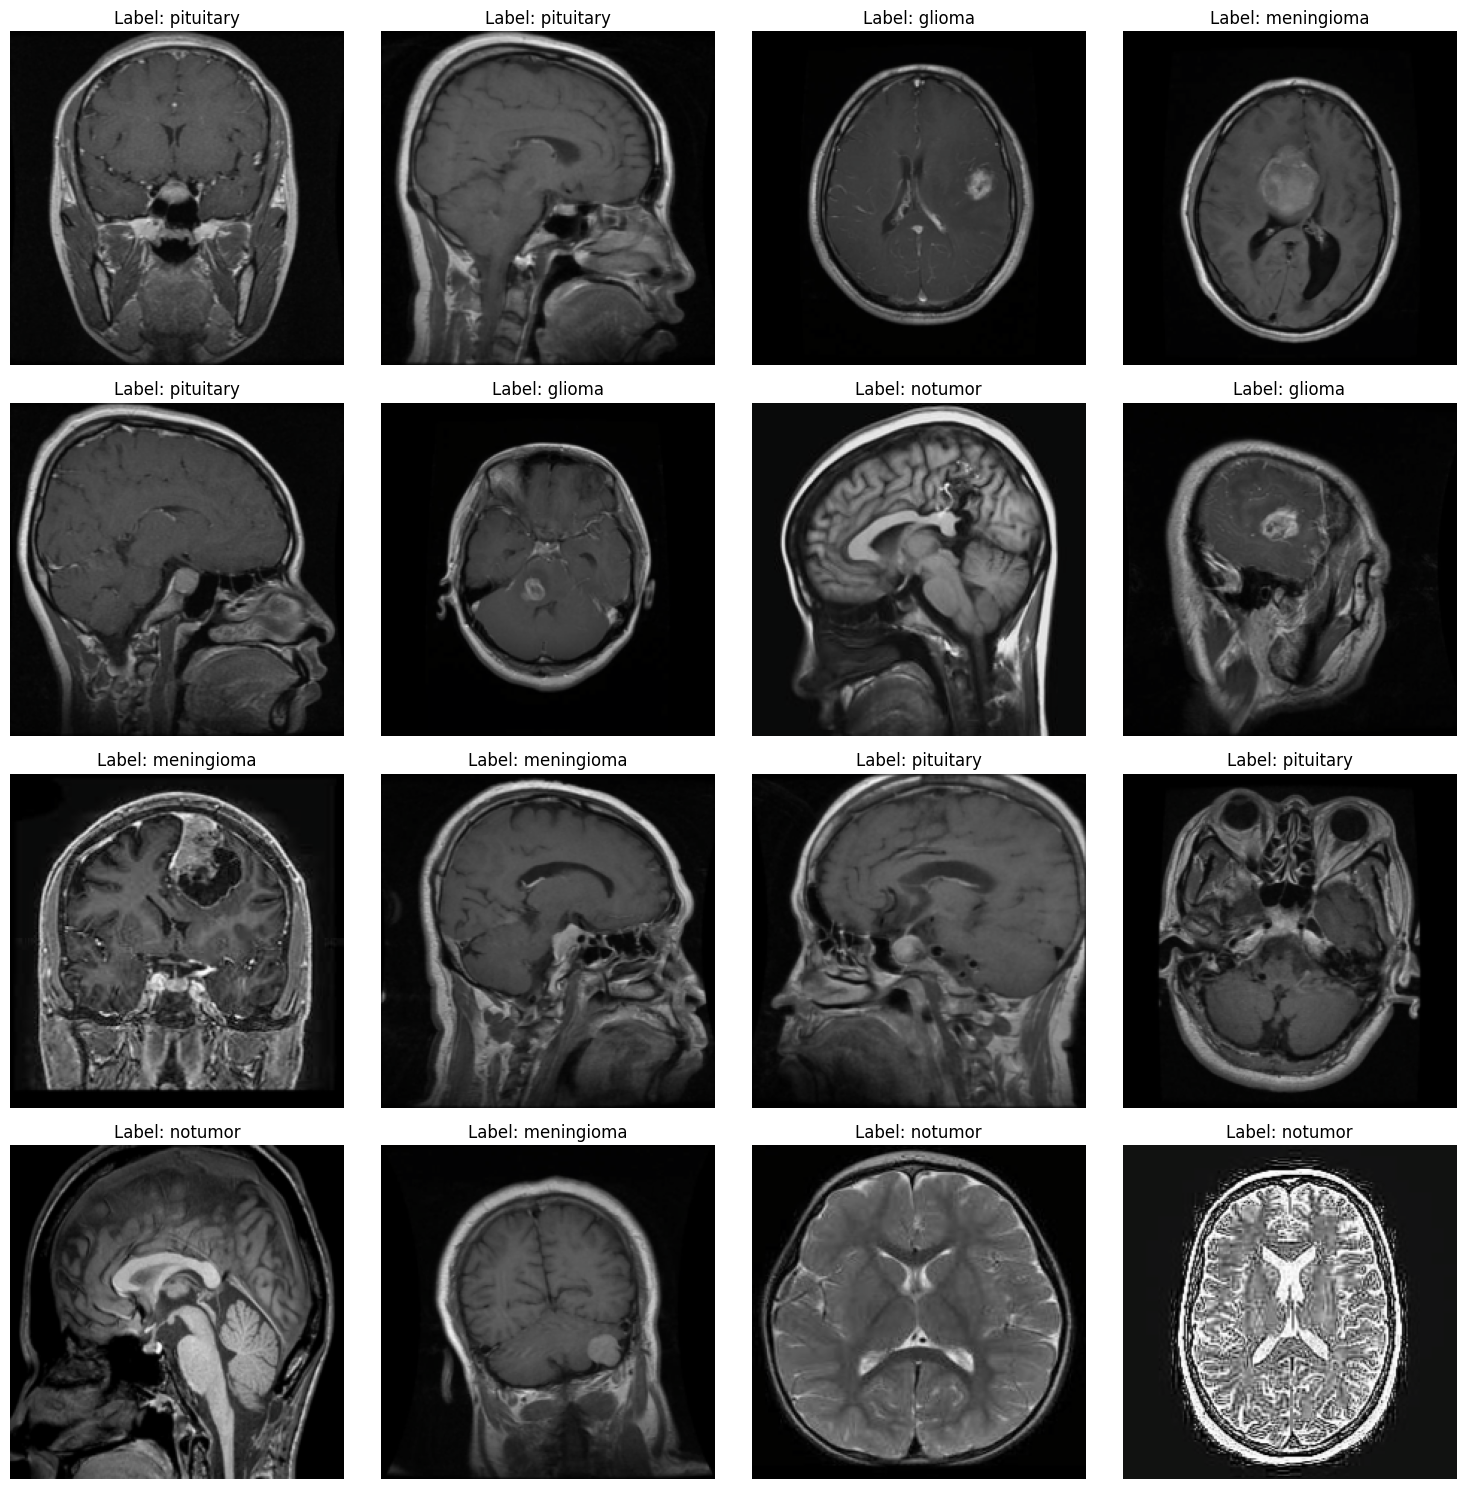

In [12]:
train_iter = iter(train_dataloader)
images,labels = next(train_iter)
num_images = len(images)
rows = int(np.ceil(num_images / 4))
images= ((images.numpy().transpose(0,2,3,1)) * STD + MEAN)
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Builing Model

In [13]:
class Custom_CNN(nn.Module):
    def __init__(self, no_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size = 3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, no_classes),
            
        )
    def forward(self,x):
        out = self.conv(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [14]:
model = Custom_CNN(no_classes=4).to(device)

In [15]:
model

Custom_CNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [16]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

In [17]:
def acc(outputs,labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum()
    return correct
    

In [34]:
epochs = 20

def train(epochs,model,loss_function,optimizer):
    history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images,labels in train_dataloader:
            images,labels = images.to(device),labels.to(device)
            optimizer.zero_grad()
            out = model(images)
            loss = loss_function(out,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total += images.shape[0]
            correct += acc(out,labels).item()
        train_accuracy = correct /total
        
        
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images,labels in test_dataloader:
                images,labels = images.to(device),labels.to(device)
                out = model(images)
                loss = loss_function(out,labels)
                val_loss += loss.item()
                total += images.shape[0]
                correct += acc(out,labels).item()
        val_accuracy = correct /total

        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        print(f"Epoch {epoch+1} / {epochs}:")
        print(f"Loss: {history['train_loss'][-1]:.4f} | Accuracy: {history['train_acc'][-1]:.4f} |" 
        f"Val Loss: {history['val_loss'][-1]:.4f} | Val Accuracy: {history['val_acc'][-1]:.4f}")
    return history
      

In [35]:
history = train(epochs= 20 , model=model,loss_function = loss_function,optimizer=optimizer)

Epoch 1 / 20:
Loss: 249.1236 | Accuracy: 0.7278 |Val Loss: 133.9251 | Val Accuracy: 0.4966
Epoch 2 / 20:
Loss: 214.0693 | Accuracy: 0.7689 |Val Loss: 768.5301 | Val Accuracy: 0.3349
Epoch 3 / 20:
Loss: 191.9252 | Accuracy: 0.7845 |Val Loss: 61.4579 | Val Accuracy: 0.6918
Epoch 4 / 20:
Loss: 169.6195 | Accuracy: 0.8171 |Val Loss: 62.9010 | Val Accuracy: 0.7483
Epoch 5 / 20:
Loss: 149.7217 | Accuracy: 0.8447 |Val Loss: 57.0112 | Val Accuracy: 0.7475
Epoch 6 / 20:
Loss: 141.0885 | Accuracy: 0.8494 |Val Loss: 92.0896 | Val Accuracy: 0.6659
Epoch 7 / 20:
Loss: 133.1292 | Accuracy: 0.8599 |Val Loss: 40.0670 | Val Accuracy: 0.7994
Epoch 8 / 20:
Loss: 115.3992 | Accuracy: 0.8836 |Val Loss: 40.2659 | Val Accuracy: 0.8268
Epoch 9 / 20:
Loss: 106.4354 | Accuracy: 0.8916 |Val Loss: 31.7890 | Val Accuracy: 0.8528
Epoch 10 / 20:
Loss: 101.6102 | Accuracy: 0.8979 |Val Loss: 28.5022 | Val Accuracy: 0.8566
Epoch 11 / 20:
Loss: 95.1657 | Accuracy: 0.9028 |Val Loss: 37.4668 | Val Accuracy: 0.8436
Epoch 1

In [36]:
def plot_loss(train_loss,val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        

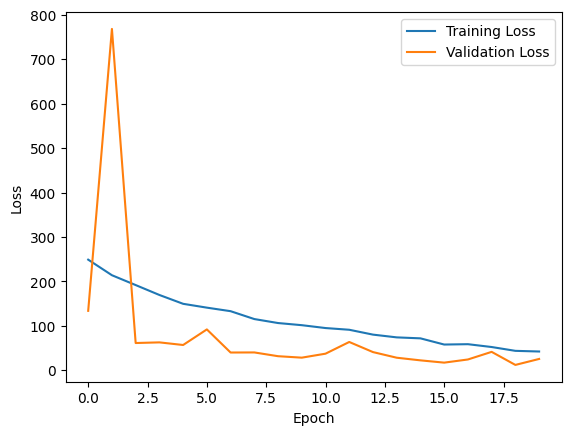

In [37]:
plot_loss(history['train_loss'],history['val_loss'])

In [38]:
def plot_acc(train_acc,val_acc):
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

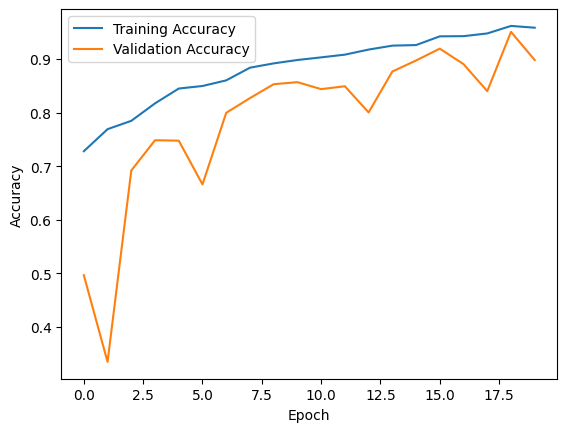

In [39]:
plot_acc(history['train_acc'],history['val_acc'])

# Using ResNet50

In [40]:
model=resnet50().to(device)

In [41]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [43]:
model.fc = nn.Linear(model.fc.in_features,4).to(device)

In [44]:
model.fc 

Linear(in_features=2048, out_features=4, bias=True)

In [45]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [46]:
history = train(epochs= 20 , model=model,loss_function = loss_function,optimizer=optimizer)

Epoch 1 / 20:
Loss: 498.9964 | Accuracy: 0.5047 |Val Loss: 75.8389 | Val Accuracy: 0.6545
Epoch 2 / 20:
Loss: 280.9427 | Accuracy: 0.6840 |Val Loss: 59.7096 | Val Accuracy: 0.6934
Epoch 3 / 20:
Loss: 242.1714 | Accuracy: 0.7323 |Val Loss: 231.2980 | Val Accuracy: 0.4943
Epoch 4 / 20:
Loss: 215.2695 | Accuracy: 0.7672 |Val Loss: 48.9137 | Val Accuracy: 0.7559
Epoch 5 / 20:
Loss: 182.7266 | Accuracy: 0.8046 |Val Loss: 57.1950 | Val Accuracy: 0.7445
Epoch 6 / 20:
Loss: 156.1166 | Accuracy: 0.8403 |Val Loss: 43.4476 | Val Accuracy: 0.7757
Epoch 7 / 20:
Loss: 139.4897 | Accuracy: 0.8540 |Val Loss: 34.0967 | Val Accuracy: 0.8314
Epoch 8 / 20:
Loss: 127.3538 | Accuracy: 0.8692 |Val Loss: 42.7774 | Val Accuracy: 0.8116
Epoch 9 / 20:
Loss: 112.3907 | Accuracy: 0.8864 |Val Loss: 59.1502 | Val Accuracy: 0.7498
Epoch 10 / 20:
Loss: 103.0327 | Accuracy: 0.8937 |Val Loss: 41.7679 | Val Accuracy: 0.8238
Epoch 11 / 20:
Loss: 95.7710 | Accuracy: 0.9044 |Val Loss: 24.9432 | Val Accuracy: 0.8879
Epoch 12

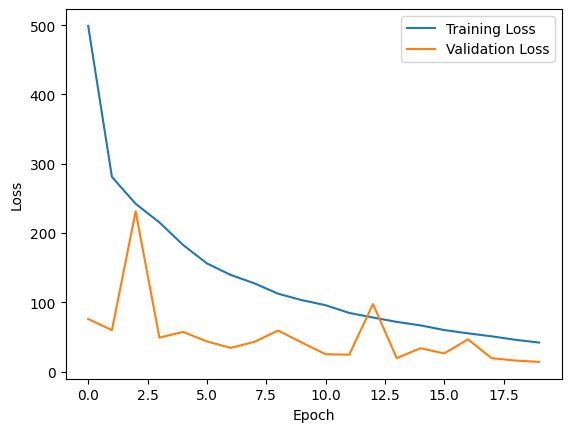

In [47]:
plot_loss(history['train_loss'],history['val_loss'])

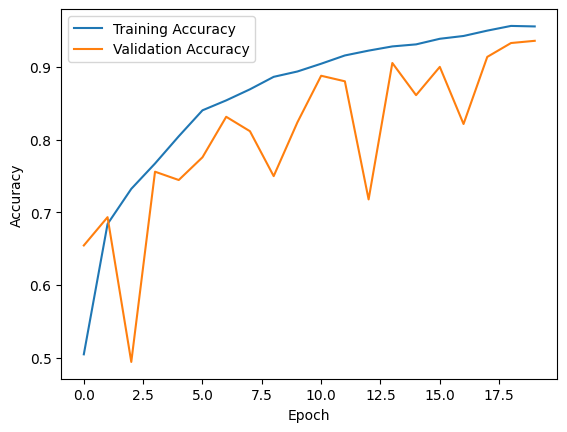

In [48]:
plot_acc(history['train_acc'],history['val_acc'])

# Using Vgg16

In [49]:
model = vgg16().to(device)

In [50]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [60]:
model.classifier[6] =  nn.Linear(model.classifier[6].in_features,4).to(device)

In [61]:
history = train(epochs= 20 , model=model,loss_function = loss_function,optimizer=optimizer)

Epoch 1 / 20:
Loss: 494.2426 | Accuracy: 0.2665 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 2 / 20:
Loss: 493.8727 | Accuracy: 0.2638 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 3 / 20:
Loss: 493.6001 | Accuracy: 0.2710 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 4 / 20:
Loss: 494.0431 | Accuracy: 0.2645 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 5 / 20:
Loss: 493.8938 | Accuracy: 0.2700 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 6 / 20:
Loss: 494.0002 | Accuracy: 0.2616 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 7 / 20:
Loss: 494.4020 | Accuracy: 0.2581 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 8 / 20:
Loss: 494.3467 | Accuracy: 0.2596 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 9 / 20:
Loss: 494.1934 | Accuracy: 0.2661 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 10 / 20:
Loss: 494.3047 | Accuracy: 0.2610 |Val Loss: 113.2900 | Val Accuracy: 0.3059
Epoch 11 / 20:
Loss: 493.9695 | Accuracy: 0.2584 |Val Loss: 113.2900 | Val Accuracy: 0.30